In [1]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, AncillaRegister
from qiskit.circuit import Gate
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from typing import Any
import csv
from datetime import datetime

In [44]:
def encode(variable: NDArray[np.float64], link_qubits: int, num_links: int) -> Statevector:

    flatened = variable.flatten()
    #copy the distribution for each link
    state = np.concatenate([flatened for _ in range(num_links)])

    #complete state by adding empty link subspaces
    max_links = 2**link_qubits
    state = np.concatenate([state] + [np.zeros(len(flatened)) for _ in range(num_links, max_links)])

    state = Statevector(state / np.linalg.norm(state))

    ancilla = Statevector([1.0, 0.0])

    return state.expand(ancilla)

In [62]:
def recover_quantity(state: Statevector, site_qubits: int, link_qubits: int, original_norm: np.float64) -> NDArray[np.float64]:
    # Get the statevector as numpy array
    state_array = np.array(state)
    
    # Calculate dimensions of the lattice
    num_sites = 2**site_qubits
    sites_per_dim = int(np.sqrt(num_sites))
    
    # Get number of active link directions
    num_links = 2**link_qubits
    
    # Initialize density array
    density = np.zeros((sites_per_dim, sites_per_dim), dtype=complex)
    
    # Sum up contributions from each link direction
    for i in range(num_links):
        # Extract values for this link direction
        start_idx = i * num_sites
        end_idx = (i + 1) * num_sites
        link_vals = state_array[start_idx:end_idx]
        
        # Reshape and add to total density
        density += link_vals.reshape((sites_per_dim, sites_per_dim))
    
    density = np.real(density)
    return original_norm * density / np.linalg.norm(density)

In [3]:
def lambda_gate(lambda_val: np.float64) -> Gate:
    qc = QuantumCircuit(1, name='lambda')
    qc.p(lambda_val, 0)
    qc.x(0)
    qc.p(lambda_val,0)
    qc.x(0)

    return qc.to_gate(label=f'lambda{lambda_val:.2f}')

In [4]:
def c_gate(lambdas: NDArray[np.float64], link_qubits: int) -> Gate:
    qc = QuantumCircuit(link_qubits + 1)

    controls = list(range(1, link_qubits + 1))
    target = 0

    for i in range(len(lambdas)):
        control_state = np.binary_repr(i, link_qubits)
        qc.append(lambda_gate(lambdas[i]).control(link_qubits, ctrl_state=control_state), controls + [target])
    
    return qc.to_gate(label='C')

In [18]:
def collision(lambdas: NDArray[np.float64], site_qubits: int, link_qubits: int) -> QuantumCircuit:
    num_qubits = site_qubits + link_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    ancilla = num_qubits - 1
    targets = [0] + list(range(site_qubits, num_qubits - 1))

    qc.h(ancilla)
    qc.append(c_gate(lambdas, link_qubits).control(1, ctrl_state='0'), [ancilla] + targets)
    qc.append(c_gate(-1 * lambdas, link_qubits).control(1, ctrl_state='1'), [ancilla] + targets)
    qc.h(ancilla)

    return qc

In [6]:
def r_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits - 1, -1, -1):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='R')

def l_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='L')


In [19]:
def propagation(site_qubits: int, link_qubits: int, links: list[(int,int)]) -> QuantumCircuit:
    num_qubits = site_qubits + link_qubits
    qc = QuantumCircuit(num_qubits)
    
    num_dims = 2
    qubits_per_dim = site_qubits // num_dims

    targets = [list(range(0, qubits_per_dim)), list(range(qubits_per_dim, site_qubits))]
    controls = list(range(site_qubits, num_qubits))
    for i, link, in enumerate(links):
        if link == (0, 0):
            continue
        
        x, y = link
        control_state = np.binary_repr(i, link_qubits)
        if x == 1:
            qc.append(r_gate(qubits_per_dim).control(link_qubits, ctrl_state=control_state), controls + targets[0])
        if x == -1:
            qc.append(l_gate(qubits_per_dim).control(link_qubits, ctrl_state=control_state), controls + targets[0])
        if y == 1:
            qc.append(r_gate(qubits_per_dim).control(link_qubits, ctrl_state=control_state), controls + targets[1])
        if y == -1:
            qc.append(l_gate(qubits_per_dim).control(link_qubits, ctrl_state=control_state), controls + targets[1])

    return qc

In [8]:
def macros() -> QuantumCircuit:
    qc = QuantumCircuit(3)
    
    #qc.swap(0, 1)
    qc.h(0)
    qc.h(1)
    
    return qc

In [149]:
def animate_density_evolution(filename: str, interval: int = 100, repeat: bool = False) -> FuncAnimation:
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    # Calculate grid dimensions from the data
    grid_size = int(np.sqrt(len(df.columns)))
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(np.zeros((grid_size, grid_size)), cmap='viridis', animated=True)
    plt.colorbar(img)
    
    ax.set_title('Density Evolution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    def init():
        img.set_array(np.zeros((grid_size, grid_size)))
        return [img]
    
    def update(frame):
        # Reshape the flattened data back to 2D
        current_density = df.iloc[frame].values.reshape(grid_size, grid_size)
        img.set_array(current_density)
        img.set_clim(vmin=df.values.min(), vmax=df.values.max())
        return [img]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(df),
                        init_func=init, blit=True,
                        interval=interval, repeat=repeat)
    
    return anim

In [12]:
def display_density_heatmap(density: NDArray[np.float64], title: str = 'Density Distribution'):
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(density, cmap='viridis')
    plt.colorbar(heatmap, label='Density')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

In [68]:
def simulate_flow(initial_density: NDArray[np.float64], 
                 site_qubits: int, 
                 link_qubits: int, 
                 num_links: int,
                 lambdas: NDArray[np.float64],
                 links: list[tuple[int, int]],
                 iterations: int,
                 filename: str) -> None:
    """
    Run the quantum lattice Boltzmann simulation for the specified number of iterations
    and save results to a CSV file.
    """
    # Get original norm for proper normalization
    original_norm = np.float64(np.linalg.norm(initial_density))
    
    # Initialize CSV file with headers
    sites_per_dim = int(np.sqrt(2**site_qubits))
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write initial state as first row
        writer.writerow(initial_density.flatten())
        
        # Initialize state
        state = encode(initial_density, link_qubits, num_links)
        
        # Create quantum circuit for one iteration
        qc = QuantumCircuit(state.num_qubits)
        qc.append(collision(lambdas, site_qubits, link_qubits), list(range(state.num_qubits)))
        qc.append(propagation(site_qubits, link_qubits, links), list(range(0, state.num_qubits - 1)))
        
        # Evolution loop
        for _ in range(iterations):
            # Evolve state
            state = state.evolve(qc)
            
            # Recover density and normalize
            density = recover_quantity(state, site_qubits, link_qubits, original_norm)
            
            # Write current state to CSV
            writer.writerow(density.flatten())
            
            # Re-encode for next iteration
            state = encode(density, link_qubits, num_links)

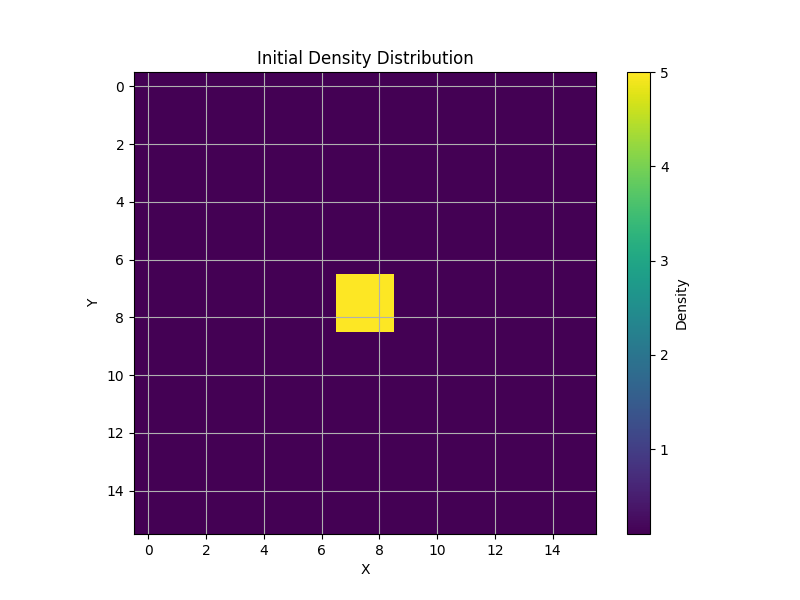

Simulation complete. Results saved to experiments/D2Q9/density_evolution_20250504_220723.csv


In [ ]:
sites = (16, 16)

velocities = [0, -1, 1, -1, 1, -1, 1, -1, 1]
links = [(0,0), (-1, 0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]
weights = np.array([2/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10])
speed_of_sound = 1/np.sqrt(3)
advection = np.array([0, 0.2, 0.2, 0.15, 0.15, 0.1, 0.1, 0.2, 0.2])
iterations = 10

lambdas = np.array([np.arccos(w * (1 + (v * u)/speed_of_sound**2)) for w, v,u in zip(weights, velocities, advection)])

density = np.full(sites, 0.1)
density[8, 8] = 5.0
density[7, 8] = 5.0
density[8, 7] = 5.0
density[7, 7] = 5.0

site_qubits = int(np.ceil(np.log2(sites[0] * sites[1])))
link_qubits = int(np.ceil(np.log2(len(links))))

# Create unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"experiments/D2Q9/density_evolution_{timestamp}.csv"

# Run simulation
simulate_flow(density, site_qubits, link_qubits, len(links), lambdas, links, iterations, filename)

print(f"Simulation complete. Results saved to {filename}")

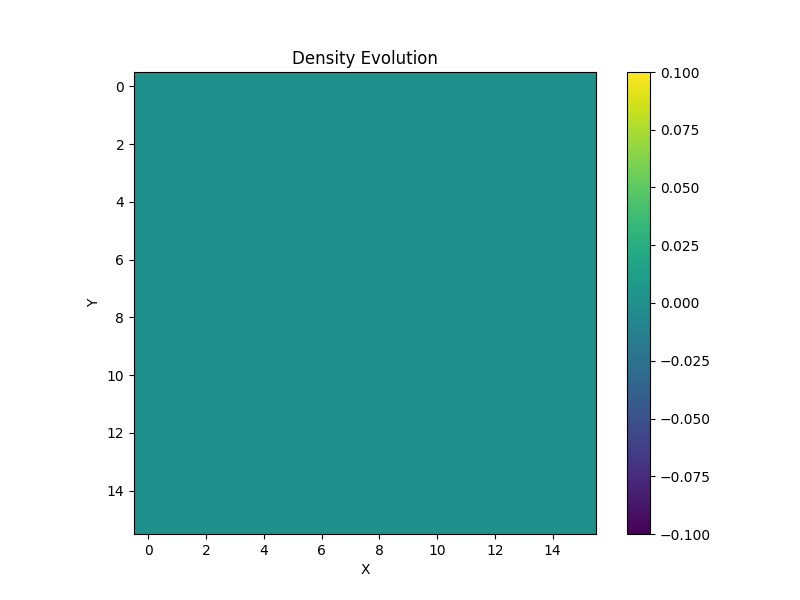

In [172]:
# Create animation
%matplotlib widget
anim = animate_density_evolution(filename, interval=100)
plt.show()